In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import scipy.stats as st
import os
import numpy as np
import random
from scipy.stats import linregress
from scipy.stats import pearsonr
import hvplot.pandas
import requests

Full Data Set

In [2]:
# Note you are pulling this from a file outside of your analysis folder, you will need to change code in the analysis section
movie_start_award_df = pd.read_csv('../Data/starting_7351.csv')
movie_start_award_df.shape

(7351, 15)

In [3]:
bins = [0, 10000000, 20000000, 30000000, 50000000, 1000000000]
labels = ['0 - $10M', '10M - $20M', '20M - $50M', '50M - $100M', 'Over $100M']
movie_start_award_df['budget bin'] = pd.cut(movie_start_award_df['budget'], bins, labels=labels, right=True, include_lowest=True)

/var/folders/hs/gpfk35m163v8nk31_7kfcs640000gn/T/ipykernel_17715/3944217343.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = movie_start_award_df.groupby('budget bin')['title'].count()


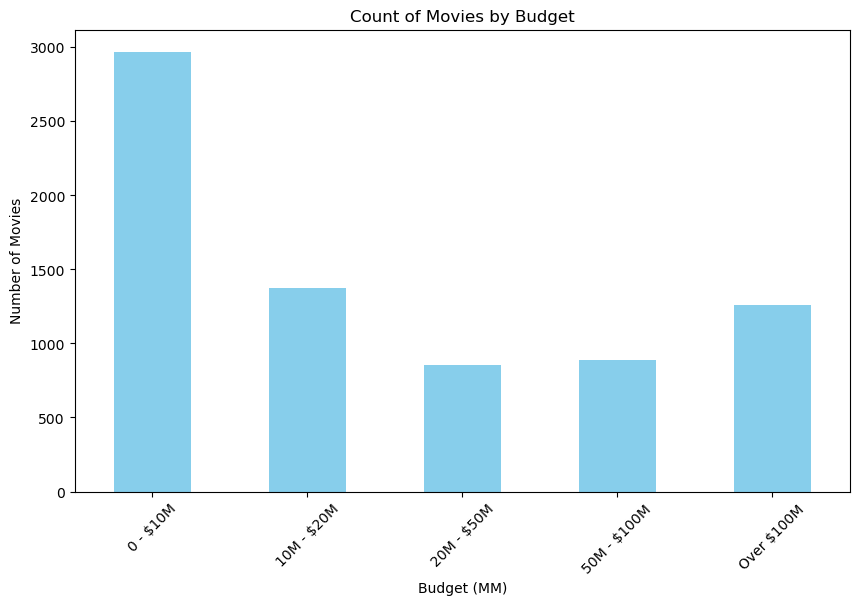

In [4]:
# Groupby Checks
grouped = movie_start_award_df.groupby('budget bin')['title'].count()

# Bar Graph
grouped.plot(kind='bar', figsize=(10, 6), color='skyblue')

# Titles and labels
plt.title('Count of Movies by Budget')
plt.xlabel('Budget (MM)')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

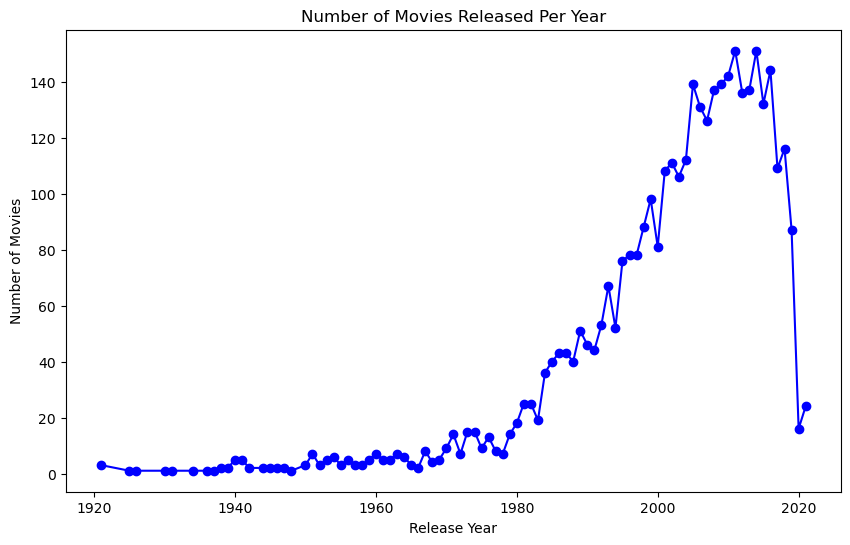

In [5]:
yearly_movies = movie_start_award_df['Year'].value_counts().sort_index()
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(yearly_movies.index, yearly_movies.values, marker='o', linestyle='-', color='b')  # Create line graph
plt.title('Number of Movies Released Per Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.grid(False)  # Enable grid for better readability
plt.show()

# Clean Data Set

In [6]:
# Note you are pulling this from a file outside of your analysis folder, you will need to change code in the analysis section
movie_final_award_df = pd.read_csv('../Data/final_1688.csv')
movie_final_award_df.shape

(1688, 15)

In [7]:
movie_final_award_df.head()

,title,revenue,budget,profit,main_genre,Runtime(Mins),Year,original_language,Director_O,Actors_O,Rating,Metascore_O,Rotten_Tomato_O,Award Wins,Award Nominations
0,Inception,825532764,160000000,665532764,Action,148.0,2010.0,en,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",8.8,74.0,87%,159.0,220.0
1,Interstellar,701729206,165000000,536729206,Adventure,169.0,2014.0,en,Christopher Nolan,"Matthew McConaughey, Anne Hathaway, Jessica Ch...",8.6,74.0,73%,0.0,0.0
2,The Dark Knight,1004558444,185000000,819558444,Action,152.0,2008.0,en,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart",9.0,84.0,94%,163.0,164.0
3,Avatar,2923706026,237000000,2686706026,Action,162.0,2009.0,en,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver",7.8,83.0,82%,91.0,131.0
4,The Avengers,1518815515,220000000,1298815515,Action,143.0,2012.0,en,Joss Whedon,"Robert Downey Jr., Chris Evans, Scarlett Johan...",8.0,69.0,91%,39.0,81.0


In [8]:
movie_final_award_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1688 non-null   object 
 1   revenue            1688 non-null   int64  
 2   budget             1688 non-null   int64  
 3   profit             1688 non-null   int64  
 4   main_genre         1688 non-null   object 
 5   Runtime(Mins)      1688 non-null   float64
 6   Year               1688 non-null   float64
 7   original_language  1688 non-null   object 
 8   Director_O         1684 non-null   object 
 9   Actors_O           1688 non-null   object 
 10  Rating             1688 non-null   float64
 11  Metascore_O        1672 non-null   float64
 12  Rotten_Tomato_O    1678 non-null   object 
 13  Award Wins         1688 non-null   float64
 14  Award Nominations  1688 non-null   float64
dtypes: float64(6), int64(3), object(6)
memory usage: 197.9+ KB


In [9]:
def convert_to_float(x):
    try:
        if isinstance(x, (int, float)):
            return float(x)
        if isinstance(x, str):
            if '%' in x:
                return float(x.strip('%')) / 100  # Convert to decimal
            return float(x)
    except (ValueError, TypeError):
        return np.nan
    
movie_final_award_df['Rotten_Tomato_O'] = movie_final_award_df['Rotten_Tomato_O'].apply(convert_to_float)
print(movie_final_award_df['Rotten_Tomato_O'])

0       0.87
1       0.73
2       0.94
3       0.82
4       0.91
        ... 
1683    0.83
1684    0.69
1685    0.50
1686    0.71
1687    0.88
Name: Rotten_Tomato_O, Length: 1688, dtype: float64


In [10]:
# Get Rotten Tomatoes, Rating, to be the same scael as the Metadata rating so all three ratings can be compared against one another. 
if movie_final_award_df['Rotten_Tomato_O'].max() <= 1.0:
    movie_final_award_df['Rotten_Tomato_O'] = (movie_final_award_df['Rotten_Tomato_O'] * 100)

# Apply multiplication to 'Rating' if it hasn't been scaled up yet
if movie_final_award_df['Rating'].max() <= 10:
    movie_final_award_df['Rating'] = (movie_final_award_df['Rating'] * 10)

movie_final_award_df.head()

,title,revenue,budget,profit,main_genre,Runtime(Mins),Year,original_language,Director_O,Actors_O,Rating,Metascore_O,Rotten_Tomato_O,Award Wins,Award Nominations
0,Inception,825532764,160000000,665532764,Action,148.0,2010.0,en,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",88.0,74.0,87.0,159.0,220.0
1,Interstellar,701729206,165000000,536729206,Adventure,169.0,2014.0,en,Christopher Nolan,"Matthew McConaughey, Anne Hathaway, Jessica Ch...",86.0,74.0,73.0,0.0,0.0
2,The Dark Knight,1004558444,185000000,819558444,Action,152.0,2008.0,en,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart",90.0,84.0,94.0,163.0,164.0
3,Avatar,2923706026,237000000,2686706026,Action,162.0,2009.0,en,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver",78.0,83.0,82.0,91.0,131.0
4,The Avengers,1518815515,220000000,1298815515,Action,143.0,2012.0,en,Joss Whedon,"Robert Downey Jr., Chris Evans, Scarlett Johan...",80.0,69.0,91.0,39.0,81.0


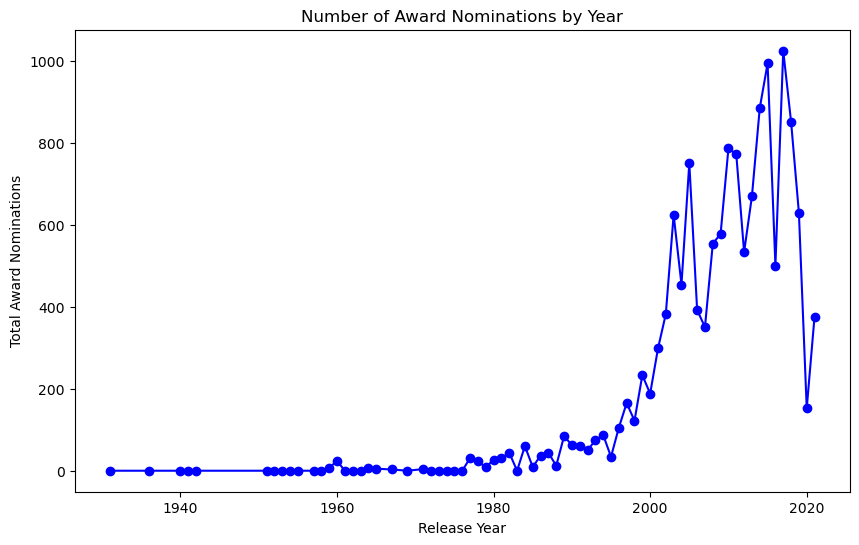

In [11]:
nominations_by_year = movie_final_award_df.groupby('Year')['Award Nominations'].sum()

# Reset index to make 'Release Year' a column again for easier plotting
nominations_by_year = nominations_by_year.reset_index()
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(nominations_by_year['Year'], nominations_by_year['Award Nominations'], marker='o', linestyle='-', color='b')
plt.title('Number of Award Nominations by Year')
plt.xlabel('Release Year')
plt.ylabel('Total Award Nominations')
plt.grid(False)  # Enable grid for better readability
plt.show()

The r-value is: PearsonRResult(statistic=0.34341665009999695, pvalue=6.422751313719934e-48)


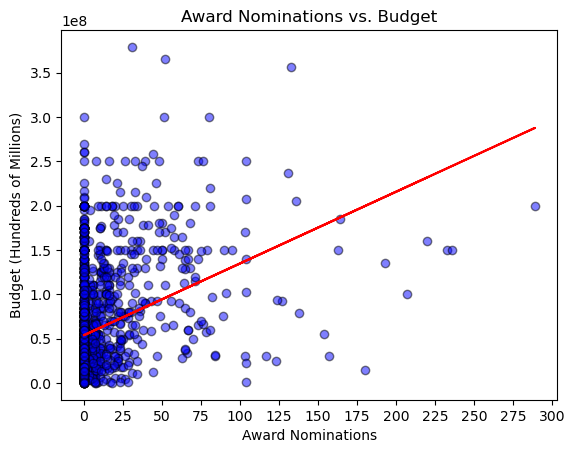

In [12]:
# Define my x and y axis
award_noms_x = movie_final_award_df['Award Nominations']
total_gross_y = movie_final_award_df['budget']

# Correlation
correlation = st.pearsonr(award_noms_x, total_gross_y) 

#Linear Regression
(slope, intercept, r_value, p_value, std_err) = linregress(award_noms_x, total_gross_y)
regress_values = award_noms_x * slope + intercept
line_eq = f"y = {round(slope,2)}x + {round(intercept,2)}"

plt.scatter(award_noms_x, total_gross_y, 
            marker='o', 
            facecolors='blue', 
            edgecolors='black',
            alpha=0.5)

plt.plot(award_noms_x, regress_values, "r-")  # Corrected to use regress_values
#plt.annotate(line_eq, xy=(0.05, 0.95), xycoords='axes fraction',
#             fontsize=12, color="red", verticalalignment='top')

ax = plt.gca() 
ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
ax.xaxis.set_major_locator(ticker.MaxNLocator(15))

# Title, labels, and aesthetics
plt.title('Award Nominations vs. Budget')
plt.xlabel('Award Nominations')
plt.ylabel('Budget (Hundreds of Millions)')
plt.grid(False)

print(f'The r-value is: {correlation}')

The r-value is: PearsonRResult(statistic=0.2292271143609786, pvalue=1.4538695798120637e-21)


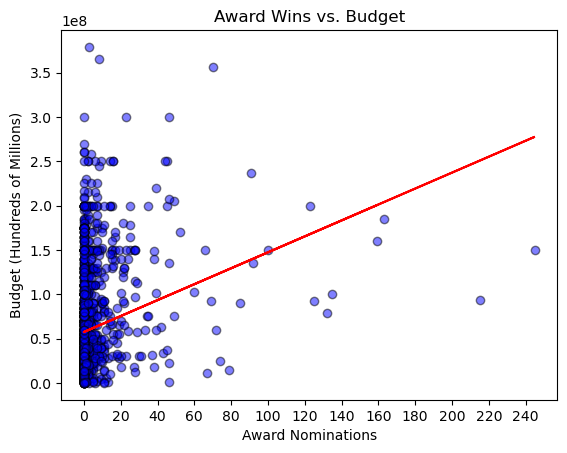

In [13]:
# Define my x and y axis
award_noms_x = movie_final_award_df['Award Wins']
total_gross_y = movie_final_award_df['budget']

# Correlation
correlation = st.pearsonr(award_noms_x, total_gross_y) 

#Linear Regression
(slope, intercept, r_value, p_value, std_err) = linregress(award_noms_x, total_gross_y)
regress_values = award_noms_x * slope + intercept
line_eq = f"y = {round(slope,2)}x + {round(intercept,2)}"

plt.scatter(award_noms_x, total_gross_y, 
            marker='o', 
            facecolors='blue', 
            edgecolors='black',
            alpha=0.5)

plt.plot(award_noms_x, regress_values, "r-")  # Corrected to use regress_values
#plt.annotate(line_eq, xy=(0.05, 0.95), xycoords='axes fraction',
#             fontsize=12, color="red", verticalalignment='top')

ax = plt.gca() 
ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
ax.xaxis.set_major_locator(ticker.MaxNLocator(15))

# Title, labels, and aesthetics
plt.title('Award Wins vs. Budget')
plt.xlabel('Award Nominations')
plt.ylabel('Budget (Hundreds of Millions)')
plt.grid(False)

print(f'The r-value is: {correlation}')

In [17]:
bins = [0, 10000000, 25000000, 50000000, 100000000, 200000000, 1000000000]
labels = ['0 - $10M', '$10M - $25M', '$25M - $50M', '$50M - $100M', '$100M - $200M', 'Over $200M']
movie_final_award_df['budget bin'] = pd.cut(movie_final_award_df['budget'], bins, labels=labels, right=False, include_lowest=True)
grouped = movie_final_award_df.groupby('budget bin')['Award Wins'].agg(sum='sum', mean='mean', count='count')

/var/folders/hs/gpfk35m163v8nk31_7kfcs640000gn/T/ipykernel_17715/440665329.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = movie_final_award_df.groupby('budget bin')['Award Wins'].agg(sum='sum', mean='mean', count='count')


/var/folders/hs/gpfk35m163v8nk31_7kfcs640000gn/T/ipykernel_17715/1277024558.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(grouped.index, rotation=45)


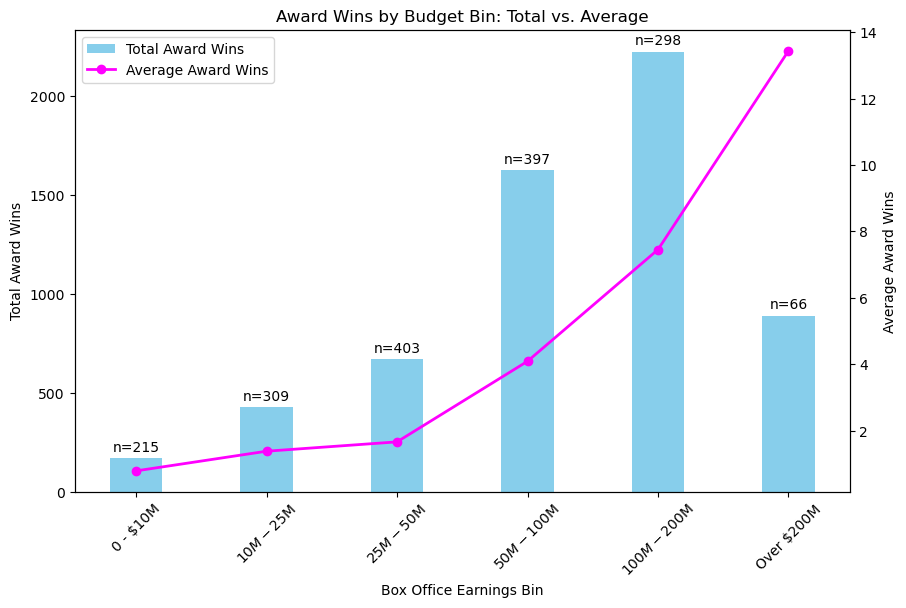

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the total awards as bars
bars = ax.bar(grouped.index, grouped['sum'], label='Total Award Wins', color='skyblue', width=0.4)

# Annotating each bar with the number of movies in the bin
for bar, count in zip(bars, grouped['count']):
    ax.annotate(f'n={count}', 
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
    
# Creating a secondary axis to plot the mean
ax2 = ax.twinx()
line = ax2.plot(grouped.index, grouped['mean'], label='Average Award Wins', color='magenta', marker='o', linewidth=2)

# Adding labels and title
ax.set_title('Award Wins by Budget Bin: Total vs. Average')
ax.set_xlabel('Box Office Earnings Bin')
ax.set_ylabel('Total Award Wins')
ax2.set_ylabel('Average Award Wins')
ax.set_xticklabels(grouped.index, rotation=45)

# Combining legends from both plots
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

/var/folders/hs/gpfk35m163v8nk31_7kfcs640000gn/T/ipykernel_17715/1783927520.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_scores = movie_final_award_df.groupby('budget bin').agg({


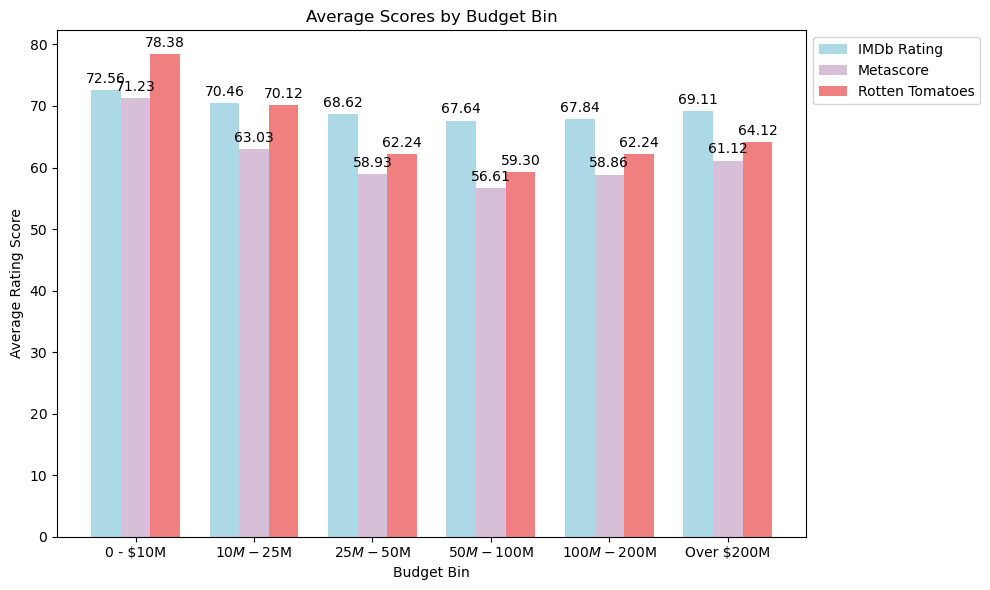

In [24]:
# Group by 'budget bin' and calculate mean for each score
mean_scores = movie_final_award_df.groupby('budget bin').agg({
    'Rating': 'mean',
    'Metascore_O': 'mean',
    'Rotten_Tomato_O': 'mean'
}).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.25  # width of the bars

# Generating x positions for the bar groups
x = range(len(mean_scores))

bars1 = ax.bar(x, mean_scores['Rating'], width=width, color='lightblue', label='IMDb Rating', align='center')
bars2 = ax.bar([p + width for p in x], mean_scores['Metascore_O'], width=width, color='thistle', label='Metascore', align='center')
bars3 = ax.bar([p + width*2 for p in x], mean_scores['Rotten_Tomato_O'], width=width, color='lightcoral', label='Rotten Tomatoes', align='center')

# Adding labels and title
ax.set_xlabel('Budget Bin')
ax.set_ylabel('Average Rating Score')
ax.set_title('Average Scores by Budget Bin')
ax.set_xticks([p + width for p in x])
ax.set_xticklabels(mean_scores['budget bin'])

# Annotating the average values
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)


ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [26]:
movie_final_award_df.columns

Index(['title', 'revenue', 'budget', 'profit', 'main_genre', 'Runtime(Mins)',
       'Year', 'original_language', 'Director_O', 'Actors_O', 'Rating',
       'Metascore_O', 'Rotten_Tomato_O', 'Award Wins', 'Award Nominations',
       'budget bin'],
      dtype='object')

In [39]:
from scipy.stats import f_oneway

# Assuming 'movie_final_award_df' has a 'budget bin' column and the appropriate data
# Preparing data: Grouping by 'budget bin' and extracting each group's data for ANOVA tests
groups_rating = [group['Rating'].dropna() for name, group in movie_final_award_df.groupby('budget bin')]
groups_metascore = [group['Metascore_O'].dropna() for name, group in movie_final_award_df.groupby('budget bin')]
groups_rotten_tomato = [group['Rotten_Tomato_O'].dropna() for name, group in movie_final_award_df.groupby('budget bin')]

# Performing ANOVA for 'Rating'
anova_result_rating = f_oneway(*groups_rating)
print(f"F-statistic for Rating: {anova_result_rating.statistic:.2f}, p-value: {anova_result_rating.pvalue:.15f}")

# Performing ANOVA for 'Metascore_O'
anova_result_metascore = f_oneway(*groups_metascore)
print(f"F-statistic for Metascore_O: {anova_result_metascore.statistic:.2f}, p-value: {anova_result_metascore.pvalue:.25f}")

# Performing ANOVA for 'Rotten_Tomato_O'
anova_result_rotten_tomato = f_oneway(*groups_rotten_tomato)
print(f"F-statistic for Rotten_Tomato_O: {anova_result_rotten_tomato.statistic:.2f}, p-value: {anova_result_rotten_tomato.pvalue:.25f}")


F-statistic for Rating: 13.13, p-value: 0.000000000001459
F-statistic for Metascore_O: 25.20, p-value: 0.0000000000000000000000014
F-statistic for Rotten_Tomato_O: 22.07, p-value: 0.0000000000000000000018382


/var/folders/hs/gpfk35m163v8nk31_7kfcs640000gn/T/ipykernel_17715/1784257496.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups_rating = [group['Rating'].dropna() for name, group in movie_final_award_df.groupby('budget bin')]
/var/folders/hs/gpfk35m163v8nk31_7kfcs640000gn/T/ipykernel_17715/1784257496.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups_metascore = [group['Metascore_O'].dropna() for name, group in movie_final_award_df.groupby('budget bin')]
/var/folders/hs/gpfk35m163v8nk31_7kfcs640000gn/T/ipykernel_17715/1784257496.py:7: FutureWarning: The default of observed=False is deprecated a

The r-value is: PearsonRResult(statistic=0.2460272326034572, pvalue=1.0816601692495992e-24)


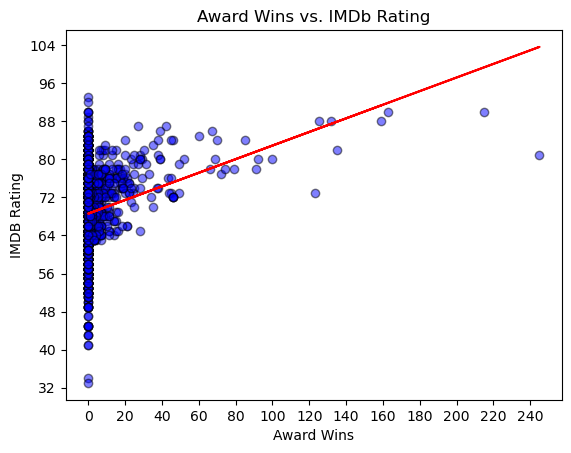

In [ ]:
# Define my x and y axis
award_x = movie_final_award_df['Award Wins']
rating_y = movie_final_award_df['Rating']

# Correlation
correlation = st.pearsonr(award_x, rating_y) 

#Linear Regression
(slope, intercept, r_value, p_value, std_err) = linregress(award_x, rating_y)
regress_values = award_x * slope + intercept
line_eq = f"y = {round(slope,2)}x + {round(intercept,2)}"

plt.scatter(award_x, rating_y, 
            marker='o', 
            facecolors='blue', 
            edgecolors='black',
            alpha=0.5)

plt.plot(award_x, regress_values, "r-")  # Corrected to use regress_values
#plt.annotate(line_eq, xy=(0.05, 0.95), xycoords='axes fraction',
#             fontsize=12, color="red", verticalalignment='top')

ax = plt.gca() 
ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
ax.xaxis.set_major_locator(ticker.MaxNLocator(15))

# Title, labels, and aesthetics
plt.title('Award Wins vs. IMDb Rating')
plt.xlabel('Award Wins')
plt.ylabel('IMDB Rating')
plt.grid(False)

print(f'The r-value is: {correlation}')

The r-value is: PearsonRResult(statistic=0.24090029312415714, pvalue=1.0342689927261785e-23)


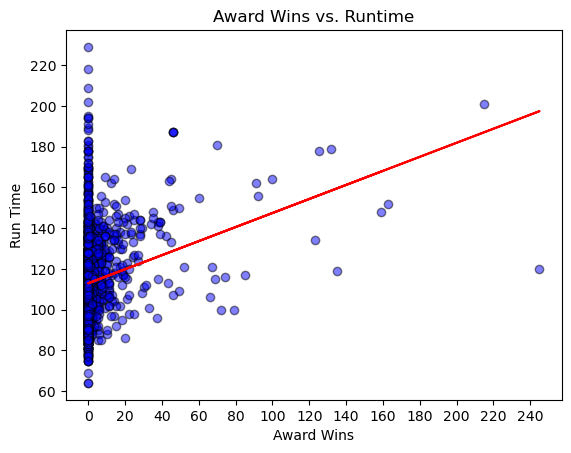

In [ ]:
####

filtered_df = movie_final_award_df[movie_final_award_df['Award Wins'] > 0]
# Define my x and y axis
award_x = movie_final_award_df['Award Wins']
rating_y = movie_final_award_df['Runtime(Mins)']

# Correlation
correlation = st.pearsonr(award_x, rating_y) 

#Linear Regression
(slope, intercept, r_value, p_value, std_err) = linregress(award_x, rating_y)
regress_values = award_x * slope + intercept
line_eq = f"y = {round(slope,2)}x + {round(intercept,2)}"

plt.scatter(award_x, rating_y, 
            marker='o', 
            facecolors='blue', 
            edgecolors='black',
            alpha=0.5)

plt.plot(award_x, regress_values, "r-")  # Corrected to use regress_values
#plt.annotate(line_eq, xy=(0.05, 0.95), xycoords='axes fraction',
#             fontsize=12, color="red", verticalalignment='top')

ax = plt.gca() 
ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
ax.xaxis.set_major_locator(ticker.MaxNLocator(15))

# Title, labels, and aesthetics
plt.title('Award Wins vs. Runtime')
plt.xlabel('Award Wins')
plt.ylabel('Run Time')
plt.grid(False)

print(f'The r-value is: {correlation}')

In [ ]:
# Weighted average
weights = {'Rating': 0.33, 'Metascore_O': 0.33, 'Rotten_Tomato_O': 0.33, 'Award Wins': 0.01}
movie_final_award_df['Weighted Average'] = movie_final_award_df.apply(lambda x: sum(x[col] * weights[col] for col in weights), axis=1)

# Sort by the weighted average 
top_movies = movie_final_award_df.sort_values(by='Weighted Average', ascending=False)

# Top 5 movies
top_5_movies = top_movies.head(5)
top_movies.head(5)

,title,revenue,budget,profit,main_genre,Runtime(Mins),Year,original_language,Director_O,Actors_O,Rating,Metascore_O,Rotten_Tomato_O,Award Wins,Award Nominations,budget bin,Weighted Average,Award Wins Bin
51,The Godfather,245066411,6000000,239066411,Crime,175.0,1972.0,en,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan",92.0,100.0,97.0,0.0,0.0,0 - $10M,95.37,0-2
366,12 Angry Men,1000000,350000,650000,Crime,96.0,1957.0,en,Sidney Lumet,"Henry Fonda, Lee J. Cobb, Martin Balsam",90.0,97.0,100.0,0.0,0.0,0 - $10M,94.71,0-2
19,The Lord of the Rings: The Return of the King,1118888979,94000000,1024888979,Action,201.0,2003.0,en,Peter Jackson,"Elijah Wood, Viggo Mortensen, Ian McKellen",90.0,94.0,94.0,215.0,124.0,Over $100M,93.89,NaN
704,Casablanca,10462500,878000,9584500,Drama,102.0,1942.0,en,Michael Curtiz,"Humphrey Bogart, Ingrid Bergman, Paul Henreid",85.0,100.0,99.0,0.0,0.0,0 - $10M,93.72,0-2
104,Schindler's List,321365567,22000000,299365567,Biography,195.0,1993.0,en,Steven Spielberg,"Liam Neeson, Ralph Fiennes, Ben Kingsley",90.0,95.0,98.0,0.0,0.0,20M - $50M,93.39,0-2


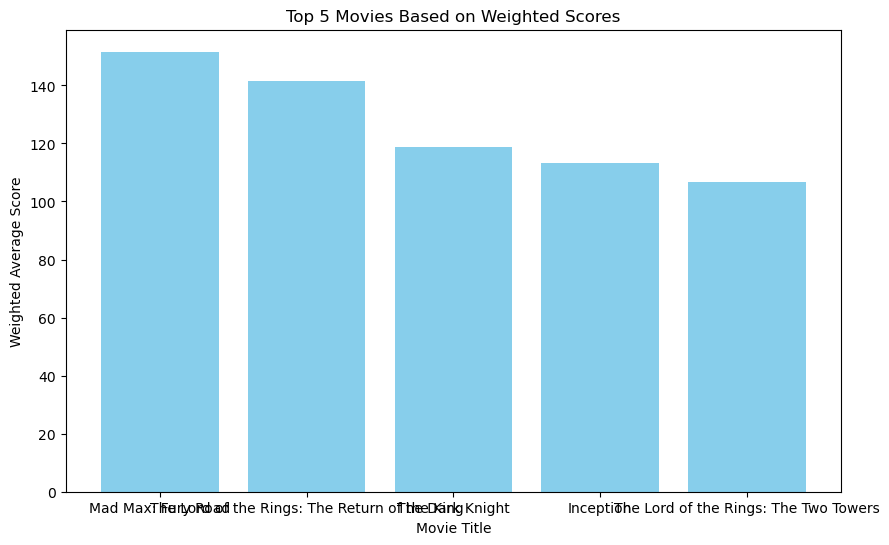

                                            title  Rating  Metascore_O  \
27                             Mad Max: Fury Road    81.0         90.0   
19  The Lord of the Rings: The Return of the King    90.0         94.0   
2                                 The Dark Knight    90.0         84.0   
0                                       Inception    88.0         74.0   
33          The Lord of the Rings: The Two Towers    88.0         87.0   

    Rotten_Tomato_O  Award Wins  Weighted Average  
27             97.0       245.0             151.6  
19             94.0       215.0             141.6  
2              94.0       163.0             118.8  
0              87.0       159.0             113.4  
33             95.0       132.0             106.8  


In [ ]:
weights = {'Rating': 0.20, 'Metascore_O': 0.20, 'Rotten_Tomato_O': 0.20, 'Award Wins': 0.40}
movie_final_award_df['Weighted Average'] = (movie_final_award_df['Rating'] * weights['Rating'] +
                         movie_final_award_df['Metascore_O'] * weights['Metascore_O'] +
                         movie_final_award_df['Rotten_Tomato_O'] * weights['Rotten_Tomato_O'] +
                         movie_final_award_df['Award Wins'] * weights['Award Wins'])

# Sort DataFrame to find top movies
df_sorted = movie_final_award_df.sort_values(by='Weighted Average', ascending=False)

# Extract top 5 movies for visualization
top_5 = df_sorted.head(5)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(top_5['title'], top_5['Weighted Average'], color='skyblue')
plt.xlabel('Movie Title')
plt.ylabel('Weighted Average Score')
plt.title('Top 5 Movies Based on Weighted Scores')
plt.show()

# Display DataFrame with specific columns
final_df = top_5[['title', 'Rating', 'Metascore_O', 'Rotten_Tomato_O', 'Award Wins', 'Weighted Average']]
print(final_df)

Select

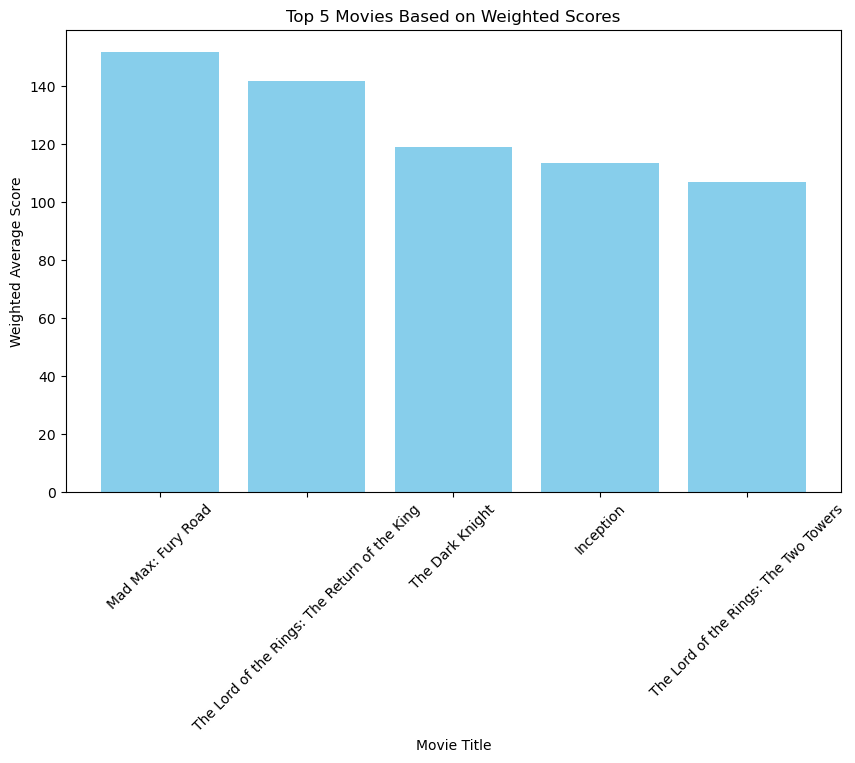

                                            title  Rating  Metascore_O  \
27                             Mad Max: Fury Road    81.0         90.0   
19  The Lord of the Rings: The Return of the King    90.0         94.0   
2                                 The Dark Knight    90.0         84.0   
0                                       Inception    88.0         74.0   
33          The Lord of the Rings: The Two Towers    88.0         87.0   

    Rotten_Tomato_O  Award Wins  Weighted Average     budget  
27             97.0       245.0             151.6  150000000  
19             94.0       215.0             141.6   94000000  
2              94.0       163.0             118.8  185000000  
0              87.0       159.0             113.4  160000000  
33             95.0       132.0             106.8   79000000  


In [ ]:
# Weighted average calculation
weights = {'Rating': 0.20, 'Metascore_O': 0.20, 'Rotten_Tomato_O': 0.20, 'Award Wins': 0.40}
movie_final_award_df['Weighted Average'] = (movie_final_award_df['Rating'] * weights['Rating'] +
                         movie_final_award_df['Metascore_O'] * weights['Metascore_O'] +
                         movie_final_award_df['Rotten_Tomato_O'] * weights['Rotten_Tomato_O'] +
                         movie_final_award_df['Award Wins'] * weights['Award Wins'])

# Sort DataFrame to find top movies
df_sorted = movie_final_award_df.sort_values(by='Weighted Average', ascending=False)

# Extract top 5 movies for visualization
top_5 = df_sorted.head(5)

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(top_5['title'], top_5['Weighted Average'], color='skyblue')

plt.xlabel('Movie Title')
plt.xticks(rotation=45)
plt.ylabel('Weighted Average Score')
plt.title('Top 5 Movies Based on Weighted Scores')
plt.show()

# Display DataFrame with specific columns including budget
final_df = top_5[['title', 'Rating', 'Metascore_O', 'Rotten_Tomato_O', 'Award Wins', 'Weighted Average', 'budget']]
print(final_df)

/var/folders/hs/gpfk35m163v8nk31_7kfcs640000gn/T/ipykernel_7780/766241108.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rating_df['Weighted Average'] = (


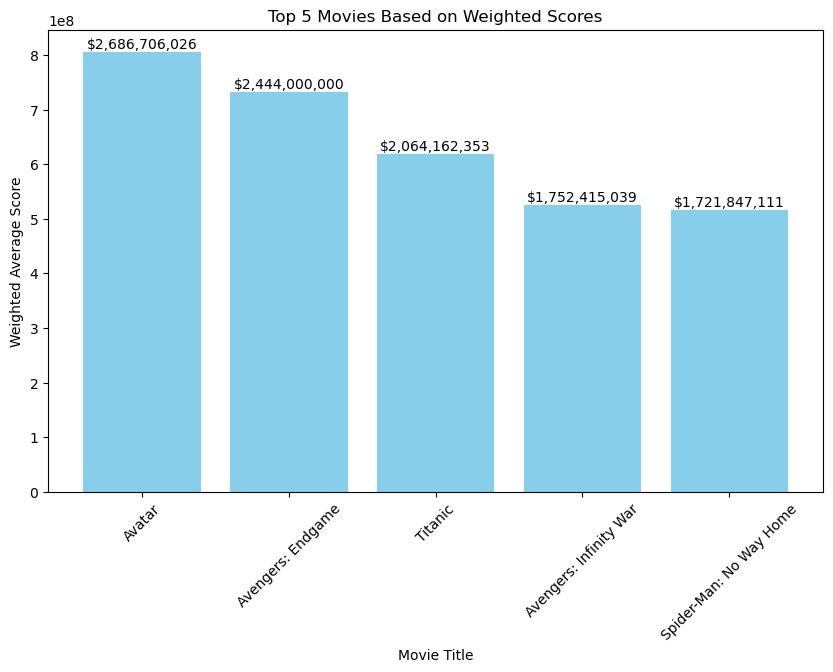

                      title  Rating  Metascore_O  Rotten_Tomato_O  Award Wins  \
3                    Avatar    78.0         83.0             82.0        91.0   
14        Avengers: Endgame    84.0         78.0             94.0        70.0   
16                  Titanic    79.0         75.0             88.0         0.0   
6    Avengers: Infinity War    84.0         68.0             85.0        46.0   
54  Spider-Man: No Way Home    83.0         71.0             93.0        35.0   

    Weighted Average     budget      profit  
3       8.060119e+08  237000000  2686706026  
14      7.332001e+08  356000000  2444000000  
16      6.192487e+08  200000000  2064162353  
6       5.257246e+08  300000000  1752415039  
54      5.165542e+08  200000000  1721847111  


In [ ]:
filtered_rating_df = movie_final_award_df[movie_final_award_df['Rotten_Tomato_O'] > 80]

# Weighted average
weights = {'Rating': 0.15, 'Metascore_O': 0.15, 'Rotten_Tomato_O': 0.15, 'Award Wins': 0.25, 'profit': 0.30}
filtered_rating_df['Weighted Average'] = (
    filtered_rating_df['Rating'] * weights['Rating'] +
    filtered_rating_df['Metascore_O'] * weights['Metascore_O'] +
    filtered_rating_df['Rotten_Tomato_O'] * weights['Rotten_Tomato_O'] +
    filtered_rating_df['Award Wins'] * weights['Award Wins'] +
    filtered_rating_df['profit'] * weights['profit'])

# Sort DataFrame to find top movies
df_sorted = filtered_rating_df.sort_values(by='Weighted Average', ascending=False)

# Extract top 5 movies for visualization
top_5 = df_sorted.head(5)

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(top_5['title'], top_5['Weighted Average'], color='skyblue')

# Adding budget labels above the bars
for bar, budget in zip(bars, top_5['profit']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'${budget:,}', 
             ha='center', va='bottom', color='black', fontsize=10)

plt.xlabel('Movie Title')
plt.xticks(rotation=45)
plt.ylabel('Weighted Average Score')
plt.title('Top 5 Movies Based on Weighted Scores')
plt.show()

# Display DataFrame with specific columns including budget
final_df = top_5[['title', 'Rating', 'Metascore_O', 'Rotten_Tomato_O', 'Award Wins', 'Weighted Average', 'budget', 'profit']]
print(final_df)


In [ ]:
final_df.head()

,title,Rating,Metascore_O,Rotten_Tomato_O,Award Wins,Weighted Average,budget,profit
3,Avatar,78.0,83.0,82.0,91.0,8.060119e+08,237000000,2686706026
14,Avengers: Endgame,84.0,78.0,94.0,70.0,7.332001e+08,356000000,2444000000
16,Titanic,79.0,75.0,88.0,0.0,6.192487e+08,200000000,2064162353
6,Avengers: Infinity War,84.0,68.0,85.0,46.0,5.257246e+08,300000000,1752415039
54,Spider-Man: No Way Home,83.0,71.0,93.0,35.0,5.165542e+08,200000000,1721847111
